In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageShow, Image
from IPython.display import display

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/AgriData",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1523 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Papper', 'Potato']

In [ ]:
len(dataset)

48

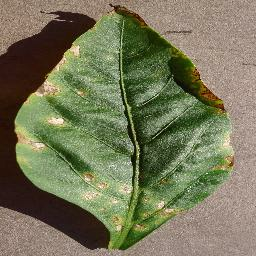

Papper


In [ ]:
for image_batch, label_batch in dataset.take(1):
  display(Image.fromarray(image_batch[0].numpy().astype("uint8")))
  print(class_names[label_batch[0]])

In [ ]:
def get_detaset_splited_into_train_val_test (ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 1000):

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(ds_size * train_split)
  val_size = int(ds_size * val_split)
  test_size = int(ds_size * test_split)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size + val_size)

  return train_ds, val_ds, test_ds


In [ ]:
train_ds, val_ds, test_ds = get_detaset_splited_into_train_val_test(dataset)

In [ ]:
print(len(train_ds), len(val_ds), len(test_ds))

38 4 6


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horixontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training = True), y)
).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
model = tf.keras.Sequential([
    keras.layers.InputLayer(shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    resize_and_rescale,
    keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(6, activation = 'softmax')
])

In [ ]:
model.build()

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,743,174 (14.28 MB)

 Trainable params: 3,743,174 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = 15
)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 191s 576ms/step - accuracy: 0.5290 - loss: 1.1673 - val_accuracy: 0.8348 - val_loss: 0.4683
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - accuracy: 0.7469 - loss: 0.5017 - val_accuracy: 0.7739 - val_loss: 0.5425
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.8496 - loss: 0.3917 - val_accuracy: 0.8870 - val_loss: 0.2857
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.8971 - loss: 0.2590 - val_accuracy: 0.8783 - val_loss: 0.3433
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.9045 - loss: 0.2522 - val_accuracy: 0.8522 - val_loss: 0.3036
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.9173 - loss: 0.2299 - val_accuracy: 0.9043 - val_loss: 0.3236
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.9303 - loss: 0.1812 - val_accuracy: 0.8957 - val_loss: 0.2553
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.9248 - loss: 0.2125 - val_accuracy: 

In [ ]:
scores = model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9639 - loss: 0.0871


In [ ]:
scores

[0.10072362422943115, 0.9635416865348816]

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

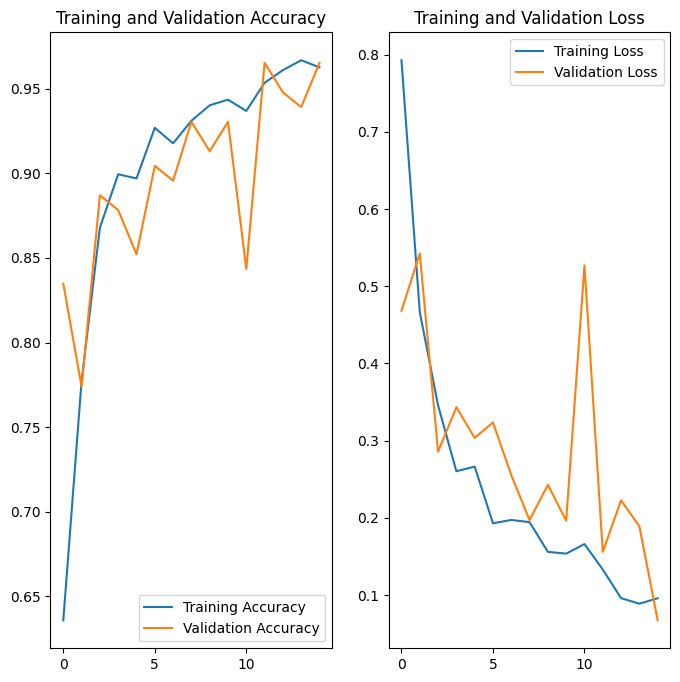

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(15), acc, label='Training Accuracy')
plt.plot(range(15), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(15), loss, label='Training Loss')
plt.plot(range(15), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


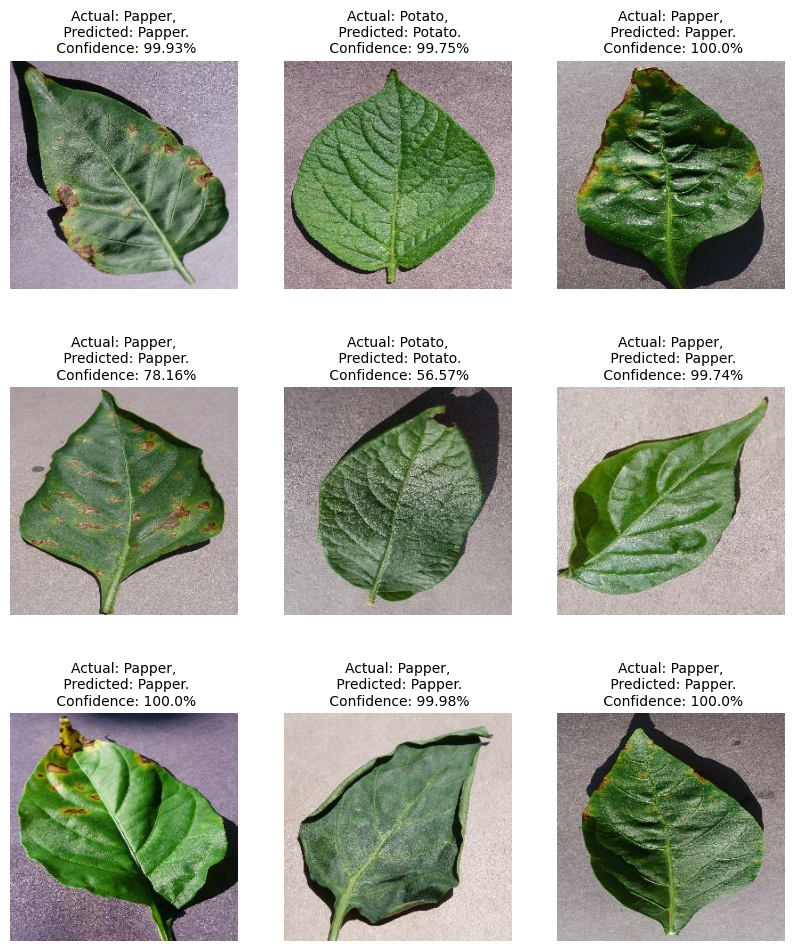

In [ ]:
plt.figure(figsize=(10, 12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%", fontsize = 10)

        plt.axis("off")

In [ ]:
import os
model.save("/content/drive/MyDrive/SavedModels/plantClassifierMode2.keras")